In [2]:
# --- 1. 환경 설정 셀 (수정된 버전) ---
import os
import sys

# 작업 디렉토리를 올바른 위치로 변경
workspace_path = '/workspace'
os.chdir(workspace_path)

# RFdiffusion 경로를 파이썬이 인식하도록 추가
rfdiffusion_path = os.path.join(workspace_path, 'RFdiffusion')
if rfdiffusion_path not in sys.path:
    sys.path.append(rfdiffusion_path)
import time
import signal
import sys
import random
import string
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

# Colab이 아닌 로컬 환경이므로, RFdiffusion 경로를 직접 추가
if 'RFdiffusion' not in sys.path:
    home_dir = os.path.expanduser("~")
    rfdiffusion_path = os.path.join(home_dir, 'RFdiffusion')
    sys.path.append(rfdiffusion_path)

os.environ["DGLBACKEND"] = "pytorch"

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

# --- Colab의 files.upload()를 대체하는 로컬 파일 처리 함수 ---
def get_pdb(pdb_code=None, use_upload=False):
    if use_upload:
        upload_widget = widgets.FileUpload(
            accept='.pdb', description='PDB 파일 업로드', button_style='info'
        )
        display(upload_widget)
        
        def wait_for_upload(widget):
            while len(widget.value) == 0: time.sleep(0.1)
            uploaded_filename = list(widget.value.keys())[0]
            pdb_content = widget.value[uploaded_filename]['content']
            pdb_filename = "tmp.pdb"
            with open(pdb_filename, "wb") as out: out.write(pdb_content)
            print(f"'{uploaded_filename}'이(가) 'tmp.pdb'로 저장되었습니다.")
            return pdb_filename
            
        return wait_for_upload(upload_widget)
    elif pdb_code is None or pdb_code == "":
        print("PDB 코드를 입력하거나 use_upload=True로 설정하세요.")
        return None
    elif os.path.isfile(pdb_code): return pdb_code
    elif len(pdb_code) == 4:
        pdb_filename = f"{pdb_code}.pdb1"
        if not os.path.isfile(pdb_filename):
            os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz && gunzip -f {pdb_code}.pdb1.gz")
        return pdb_filename
    else:
        pdb_filename = f"AF-{pdb_code}-F1-model_v4.pdb"
        if not os.path.isfile(pdb_filename):
            os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/{pdb_filename}")
        return pdb_filename

def run_ananas(pdb_str, path, sym=None):
    pdb_filename = f"outputs/{path}/ananas_input.pdb"
    out_filename = f"outputs/{path}/ananas.json"
    os.makedirs(f"outputs/{path}", exist_ok=True)
    with open(pdb_filename,"w") as handle: handle.write(pdb_str)
    cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
    if sym is None: os.system(cmd)
    else: os.system(f"{cmd} {sym}")
    try:
        with open(out_filename,"r") as f: out = json.load(f)
        results, AU = out[0], out[-1]["AU"]
        group, chains, rmsd = AU["group"], AU["chain names"], results["Average_RMSD"]
        print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")
        C = np.array(results['transforms'][0]['CENTER'])
        A = [np.array(t["AXIS"]) for t in results['transforms']]
        new_lines = []
        for line in pdb_str.split("\n"):
            if line.startswith("ATOM"):
                chain = line[21:22]
                if chain in chains:
                    x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
                    if group[0] == "c": x = sym_it(x,C,A[0])
                    if group[0] == "d": x = sym_it(x,C,A[1],A[0])
                    coord_str = "".join([f"{a:8.3f}" for a in x])
                    new_lines.append(line[:30]+coord_str+line[54:])
            else: new_lines.append(line)
        return results, "\n".join(new_lines)
    except Exception as e:
        print(f"AnAnaS 결과 처리 중 오류 발생: {e}")
        return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):
    def run_command_and_get_pid(command):
        pid_file = '/dev/shm/pid'
        os.system(f'nohup {command} > /dev/null & echo $! > {pid_file}')
        with open(pid_file, 'r') as f: pid = int(f.read().strip())
        os.remove(pid_file)
        return pid
    def is_process_running(pid):
        try: os.kill(pid, 0)
        except OSError: return False
        else: return True
    run_output = widgets.Output()
    progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
    display(widgets.VBox([progress, run_output]))
    for n in range(steps):
        if os.path.isfile(f"/dev/shm/{n}.pdb"): os.remove(f"/dev/shm/{n}.pdb")
    pid = run_command_and_get_pid(command)
    try:
        fail = False
        for _ in range(num_designs):
            for n in range(steps):
                wait = True
                while wait and not fail:
                    time.sleep(0.1)
                    if os.path.isfile(f"/dev/shm/{n}.pdb"):
                        with open(f"/dev/shm/{n}.pdb", "r") as f: pdb_str = f.read()
                        if "TER" in pdb_str or "ENDMDL" in pdb_str: wait = False
                        elif not is_process_running(pid): fail = True
                    elif not is_process_running(pid): fail = True
                if fail:
                    progress.bar_style = 'danger'; progress.description = "failed"
                    break
                else:
                    progress.value = (n+1) / steps
                    if visual != "none":
                        with run_output:
                            run_output.clear_output(wait=True)
                            if visual == "image":
                                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                                fig = plt.figure(); fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1); plt.show()
                            if visual == "interactive":
                                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                                view.addModel(pdb_str,'pdb'); view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                                view.zoomTo(); view.show()
                if os.path.exists(f"/dev/shm/{n}.pdb"): os.remove(f"/dev/shm/{n}.pdb")
            if fail:
                progress.bar_style = 'danger'; progress.description = "failed"
                break
        while is_process_running(pid): time.sleep(0.1)
    except KeyboardInterrupt:
        os.kill(pid, signal.SIGTERM); progress.bar_style = 'danger'; progress.description = "stopped"
    
def run_diffusion(contigs, path, pdb=None, iterations=50, symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False, num_designs=1, visual="none"):
    full_path = f"outputs/{path}"; os.makedirs(full_path, exist_ok=True)
    opts = [f"inference.output_prefix={full_path}", f"inference.num_designs={num_designs}"]
    if chains == "": chains = None
    if symmetry in ["auto","cyclic","dihedral"]:
        if symmetry == "auto": sym, copies = None, 1
        else: sym, copies = {"cyclic":(f"c{order}",order), "dihedral":(f"d{order}",order*2)}[symmetry]
    else: symmetry = None; sym, copies = None, 1
    contigs_list = contigs.replace(","," ").replace(":"," ").split()
    is_fixed, is_free = False, False; fixed_chains = []
    for contig in contigs_list:
        for x in contig.split("/"):
            a = x.split("-")[0]
            if a and a[0].isalpha():
                is_fixed = True
                if a[0] not in fixed_chains: fixed_chains.append(a[0])
            if a.isnumeric(): is_free = True
    if len(contigs_list) == 0 or not is_free: mode = "partial"
    elif is_fixed: mode = "fixed"
    else: mode = "free"
    if mode in ["partial","fixed"]:
        pdb_str = pdb_to_string(pdb, chains=chains)
        if symmetry == "auto":
            a, pdb_str = run_ananas(pdb_str, path)
            if a is None: print(f'ERROR: no symmetry detected'); symmetry = None; sym, copies = None, 1
            else:
                if a["group"][0] == "c": symmetry = "cyclic"; sym, copies = a["group"], int(a["group"][1:])
                elif a["group"][0] == "d": symmetry = "dihedral"; sym, copies = a["group"], 2 * int(a["group"][1:])
                else: print(f'ERROR: detected symm ({a["group"]}) not supported'); symmetry = None; sym, copies = None, 1
        elif mode == "fixed": pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)
        pdb_filename = f"{full_path}/input.pdb"
        with open(pdb_filename, "w") as handle: handle.write(pdb_str)
        parsed_pdb = parse_pdb(pdb_filename)
        opts.append(f"inference.input_pdb={pdb_filename}")
        if mode in ["partial"]:
            iterations = int(80 * (iterations / 200)); opts.append(f"diffuser.partial_T={iterations}")
            contigs_list = fix_partial_contigs(contigs_list, parsed_pdb)
        else: opts.append(f"diffuser.T={iterations}"); contigs_list = fix_contigs(contigs_list, parsed_pdb)
    else:
        opts.append(f"diffuser.T={iterations}"); parsed_pdb = None
        contigs_list = fix_contigs(contigs_list, parsed_pdb)
    if hotspot is not None and hotspot != "": opts.append(f"ppi.hotspot_res=[{hotspot}]")
    if sym is not None:
        sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
        if add_potential: sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'", "potentials.olig_intra_all=True","potentials.olig_inter_all=True", "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
        opts = sym_opts + opts; contigs_list = sum([contigs_list] * copies,[])
    opts.append(f"'contigmap.contigs=[{' '.join(contigs_list)}]'")
    opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]
    print("mode:", mode); print("output:", full_path); print("contigs:", contigs_list)
    run_script_path = "/workspace/RFdiffusion/run_inference.py"
    opts_str = " ".join(opts)
    cmd = f"python {run_script_path} {opts_str}"
    print(cmd)
    run(cmd, iterations, num_designs, visual=visual)
    for n in range(num_designs):
        pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb", f"outputs/traj/{path}_{n}_Xt-1_traj.pdb", f"{full_path}_{n}.pdb"]
        for pdb_file in pdbs:
            if os.path.exists(pdb_file):
                with open(pdb_file,"r") as handle: pdb_str = handle.read()
                with open(pdb_file,"w") as handle: handle.write(fix_pdb(pdb_str, contigs_list))
    return contigs_list, copies

print("✅ Setup cell is ready.")

✅ Setup cell is ready.


✅ 결과가 저장될 폴더: outputs/0903-150-200
mode: fixed
output: outputs/0903-150-200/0903-150-200
contigs: ['C311-391', '100-100']
python /workspace/RFdiffusion/run_inference.py inference.output_prefix=outputs/0903-150-200/0903-150-200 inference.num_designs=200 inference.input_pdb=outputs/0903-150-200/0903-150-200/input.pdb diffuser.T=150 ppi.hotspot_res=[C331,C360,C378,C381,C323] 'contigmap.contigs=[C311-391 100-100]' inference.dump_pdb=True inference.dump_pdb_path='/dev/shm'


/workspace/RFdiffusion/util_module.py:259: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/Cross.cpp:62.)
  CBrotaxis1 = (CBr-CAr).cross(NCr-CAr)
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



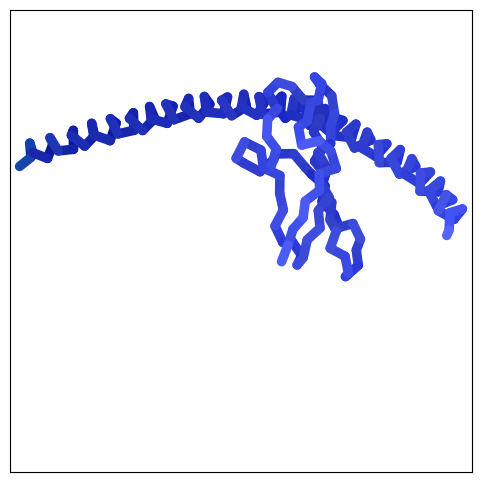

In [ ]:
# --- 바인더 디자인 실행 셀 (수정된 버전) ---

# 1. 파라미터 설정
name = "0903-150-200"
contigs = "C311-391/0 100-100"
hotspot = "C331,C360,C378,C381,C323"
iterations = 150
num_designs = 200
visual = "image"

# --- 2. 업로드한 PDB 파일 경로 직접 지정 ---
# 여기에 1단계에서 업로드한 PDB 파일의 정확한 이름을 입력하세요.
pdb_filename = "4k9e_c.pdb" 
pdb = os.path.join("/workspace", pdb_filename)

# 3. RFdiffusion 실행
# --- 이 아랫부분이 수정되었습니다 ---

# 기본 실행 이름(폴더명으로 사용될)을 설정합니다.
base_name = name
output_dir = f"outputs/{base_name}"

# 만약 동일한 이름의 폴더가 이미 존재하면, 중복을 피하기 위해 랜덤 문자열을 뒤에 붙입니다.
while os.path.exists(output_dir):
    random_suffix = ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))
    base_name = f"{name}_{random_suffix}"
    output_dir = f"outputs/{base_name}"

# run_diffusion 함수는 이 path를 파일 이름의 접두사로 사용합니다.
# 예: path가 "8051/8051" 이면, 결과는 outputs/8051/8051_0.pdb 로 저장됩니다.
path = os.path.join(base_name, base_name)

print(f"✅ 결과가 저장될 폴더: {output_dir}")
# --- 수정된 부분 끝 ---


flags = {
    "contigs": contigs, "pdb": pdb, "iterations": int(iterations),
    "hotspot": hotspot, "path": path, "num_designs": int(num_designs),
    "visual": visual, "symmetry": "none", "order": 1, "chains": "", "add_potential": True
}

for k, v in flags.items():
    if isinstance(v, str):
        flags[k] = v.replace("'", "").replace('"', '')

contigs, copies = run_diffusion(**flags)

# --- 마지막 출력 메시지도 수정되었습니다 ---
print(f"✅ RFdiffusion 실행 완료! 결과는 '{output_dir}' 폴더에 저장되었습니다.")

In [21]:
#@title Display 3D structure {run: "auto"}
animate = "none" #@param ["none", "movie", "interactive"]
color = "chain" #@param ["rainbow", "chain", "plddt"]
denoise = True
dpi = 100 #@param ["100", "200", "400"] {type:"raw"}
from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

def plot_pdb(num=0):
  if denoise:
    pdb_traj = f"outputs/traj/{path}_{num}_pX0_traj.pdb"
  else:
    pdb_traj = f"outputs/traj/{path}_{num}_Xt-1_traj.pdb"
  if animate in ["none","interactive"]:
    hbondCutoff = 4.0
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    if animate == "interactive":
      pdb_str = open(pdb_traj,'r').read()
      view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    else:
      pdb = f"outputs/{path}_{num}.pdb"
      pdb_str = open(pdb,'r').read()
      view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    if color == "rainbow":
      view.setStyle({'cartoon': {'color':'spectrum'}})
    elif color == "chain":
      for n,chain,c in zip(range(len(contigs)),
                              alphabet_list,
                              pymol_color_list):
          view.setStyle({'chain':chain},{'cartoon': {'color':c}})
    else:
      view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
    view.zoomTo()
    if animate == "interactive":
      view.animate({'loop': 'backAndForth'})
    view.show()
  else:
    Ls = get_Ls(contigs)
    xyz, bfact = get_ca(pdb_traj, get_bfact=True)
    xyz = xyz.reshape((-1,sum(Ls),3))[::-1]
    bfact = bfact.reshape((-1,sum(Ls)))[::-1]
    if color == "chain":
      display(HTML(make_animation(xyz, Ls=Ls, dpi=dpi, ref=-1)))
    elif color == "rainbow":
      display(HTML(make_animation(xyz, dpi=dpi, ref=-1)))
    else:
      display(HTML(make_animation(xyz, plddt=bfact*100, dpi=dpi, ref=-1)))


if num_designs > 1:
  output = widgets.Output()
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
      options=[(f'{k}',k) for k in range(num_designs)],
      value=0, description='design:',
  )
  dropdown.observe(on_change)
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

In [11]:
%%time
#@title run **ProteinMPNN** to generate a sequence and **AlphaFold** to validate
num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
initial_guess = True #@param {type:"boolean"}
num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
use_multimer = True #@param {type:"boolean"}
rm_aa = "C" #@param {type:"string"}
mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
#@markdown - for **binder** design, we recommend `initial_guess=True num_recycles=3`

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]
if initial_guess: opts.append("--initial_guess")
if use_multimer: opts.append("--use_multimer")
opts = ' '.join(opts)
!python -m colabdesign.rf.designability_test {opts}
import os
import pandas as pd

# 결과 파일 경로 설정
best_pdb_path = f"outputs/{path}/best.pdb"
all_results_path = f"outputs/{path}/all_results.csv"

print("\n----------------------------------------------------")
try:
    # 모든 결과 요약 출력
    if os.path.exists(all_results_path):
        print("📊 전체 디자인 결과 요약:")
        df = pd.read_csv(all_results_path)
        print(df[['design', 'n', 'plddt', 'rmsd']].to_string(index=False))
        print("----------------------------------------------------")

    # Best 모델 정보 읽어오기
    with open(best_pdb_path, "r") as f:
        info = f.readline().strip().split()
        design_num = info[3]
        seq_num = info[5]
        rmsd_val = info[7]

    # 최종 Best 모델 정보 출력
    print(f"🏆 Best 모델이 선정되었습니다! 🏆")
    print(f"   - 모델 번호: design {design_num} / sequence {seq_num}")
    print(f"   - RMSD 값: {rmsd_val}")
    print("----------------------------------------------------")

except FileNotFoundError:
    print("⚠️ 'best.pdb' 파일을 찾을 수 없습니다. 스크립트 실행에 문제가 있었을 수 있습니다.")

{'pdb':'outputs/0903-150-200/0903-150-200_0.pdb','loc':'outputs/0903-150-200/0903-150-200','contigs':'C311-391:100-100','copies':1,'num_seqs':8,'initial_guess':True,'use_multimer':True,'use_soluble':False,'num_recycles':3,'rm_aa':'C','num_designs':200,'mpnn_sampling_temp':0.1}
protocol=binder
2025-09-03 02:15:04.705183: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.8 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
running proteinMPNN...
running AlphaFold...
design:0 n:0 mpnn:1.293 plddt:0.893 i_ptm:0.069 i_pae:27.880 rmsd:60.393 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEEERRKKEEEERRKREEEERKREEEEEKEEEILELLEEIEEASEEERAKLEKEVEEDEELKRRLEEVLEKRRRREEERRARELAREAAAKAAEEALK
desi

design:3 n:6 mpnn:1.234 plddt:0.528 i_ptm:0.251 i_pae:25.689 rmsd:51.576 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEALLAALKEAAEAIAKYLEYKKIKEEAEELKREGKEEEAAKLEEEAEKFKEEAEKGKKVLALYTAVVGGAALAALLAALLALGLTVAPGPPVITHVITM
design:3 n:7 mpnn:1.163 plddt:0.619 i_ptm:0.464 i_pae:25.769 rmsd:60.008 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SMAEAAKKEAEEKAIKKAEEGKEIEEKAKELLREGKEEEAEKLKKELEEKKEEIEEGKKALAAREAKEGAAAAAAALAAAAAAGLLTLPGPPVVTITVTM
design:4 n:0 mpnn:1.092 plddt:0.870 i_ptm:0.090 i_pae:25.954 rmsd:60.000 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEEKKKKEIEELKKKAEEAEKEYEELKKKAEELKKKAEELKKKLEEGVIKEGGKKEIEELNKKYEEVKKKAEEVKYKMEKYKKEIEKLEAEEEKKKRE
design:4 n:1 mpnn:1.103 plddt:0.853 i_ptm:0.091 i_pae:25.382 rmsd:60.843 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEELKKLKKKLEELKKKAKEKQKEADELTKKAEELKAKAEELEKLIKEGKIKDKGPELVKKLKEEADEVKKKADEVK

design:7 n:7 mpnn:1.055 plddt:0.691 i_ptm:0.036 i_pae:30.302 rmsd:81.283 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEEEEERRRREEEERERAERKKREEEERRERERKEREERRAAEAAARAAAAAAAAAAAAPAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
design:8 n:0 mpnn:0.986 plddt:0.816 i_ptm:0.189 i_pae:21.999 rmsd:7.078 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEIFKKRLEERKKYFEEELKKEKEELKKELEEKIKKKEEELEKLKKEGKSEEEIKKAEEELKELKEEAKKKLEELEKKIEEEKKKEEERLKKYIKREEEE
design:8 n:1 mpnn:1.031 plddt:0.731 i_ptm:0.178 i_pae:22.163 rmsd:27.522 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEIFKKRLEERRKRFEEELEKELKELEEKLKKEIEKLEKELEKLKKEGKSEEEIKKAEEKLKKKKEEAEKKLEEKKKKIEERKKEEEKRLKEYEEREKKE
design:8 n:2 mpnn:1.043 plddt:0.711 i_ptm:0.077 i_pae:26.675 rmsd:49.713 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEIFEKRLKEKEEYFLKELEEEEKKLKEELEKEIKEKEKKLEKLKKEGVSKEEIEKAEKELKEKKEEAKKLLEEKKKK

design:11 n:7 mpnn:1.119 plddt:0.656 i_ptm:0.079 i_pae:25.892 rmsd:44.393 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKEAEELVKEIDELEKSPEYKELVEDEEEDKEKLERIKKALLKYNTKELIELVKEYLETLKKALEEAKKNGKQAIERAKSTRKELLKKIEELIEKIEKEE
design:12 n:0 mpnn:0.861 plddt:0.795 i_ptm:0.069 i_pae:26.139 rmsd:55.240 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SKRVEEIAKKLKEIIKELKKLAEELPKELAKKIEEIIKKLEEAIKLAKEGKFVEAADLLKEAAKELKELLKEFEKISKELAEKVKKIIEELEKLIKEILE
design:12 n:1 mpnn:0.957 plddt:0.879 i_ptm:0.097 i_pae:24.340 rmsd:57.057 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SERVEKFVKKLEEIIKKLKKLSKKLPPELAKKIDKLIEELKKAAELIKEGNFVEAVELLKRVAKEMEELLPELKKISPELAKEMEELIKELKELIKELEE
design:12 n:2 mpnn:0.906 plddt:0.737 i_ptm:0.078 i_pae:25.418 rmsd:56.002 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DKRVEEFVKKLKELIEKLEKIAKEVPEKLKEKLKELIKKLKEAAKLIKEGNFVEAAELLEEVAKELEELLKEF

design:15 n:7 mpnn:1.089 plddt:0.833 i_ptm:0.096 i_pae:25.333 rmsd:61.868 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKKQKLEEIEKLIKEATKKLTEAEEKLKEIEKKKEELEKELKKAEKEGKSKEEIEKLKAKLEEAKKELEKKKKELEEVKKEVEKKKQEAIDKLIEIRE
design:16 n:0 mpnn:1.196 plddt:0.830 i_ptm:0.071 i_pae:27.515 rmsd:66.000 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEKEKEEEEKKKEEKEKKRKEKEKKREEKKKITEYKKLKEKEEKEEEELKKEEEKLEKEEKKAEKENKETGKSKPKLEEIKKKKKELEKEKKEREKKKE
design:16 n:1 mpnn:1.239 plddt:0.825 i_ptm:0.074 i_pae:27.148 rmsd:44.481 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEEKKKEEEKKKEEEKKKEEKEKERKKKKEITEDKLLEKKEKEELKKIEEKLKELEEKLKKLEELNKKTGKYKPELEKVKEEKKKLEKELKEKLKKLE
design:16 n:2 mpnn:1.306 plddt:0.748 i_ptm:0.060 i_pae:28.488 rmsd:71.514 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEEKKKKEEEKKKKEEEKEKKEKEREKKKKETEAKKLEKKEKELAKALEEEKKKLKEKLEKLEKLNKETGE

design:19 n:7 mpnn:1.228 plddt:0.735 i_ptm:0.084 i_pae:25.237 rmsd:37.683 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DPFLKELEDFYKKRTAELDKISKEYDKLTGEDTSAEVKKKKAELKKKAEEIYELHKKGGDPESLKKKTEEEFKKYLAEIEKEMEKLKKEKEEKKKEEEKK
design:20 n:0 mpnn:1.090 plddt:0.863 i_ptm:0.074 i_pae:26.482 rmsd:53.639 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EIEEKKKEAEKVKEKIKKIKEELEKREAEREARLAALRAETEARIAGATAEEAARLRAALAAEEERLEAELAKYKEEKKPELEELEKEYEELEKEIKKLE
design:20 n:1 mpnn:1.084 plddt:0.904 i_ptm:0.072 i_pae:27.074 rmsd:42.186 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KLEELKKEAEKVKAKVEEIEKALKKLEEETEAALKAAEAAAAAAQAGASAAEKAAIKAELAAKKEALLAALAKKKEEAKPELEELKKELEKLEAEIKALE
design:20 n:2 mpnn:1.024 plddt:0.903 i_ptm:0.085 i_pae:25.965 rmsd:57.354 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KKEELKKEAQKVKEKLEKLEEELKKLEEEVEKKLKELEEEAEKKIKGATKEEKEEILKKLEEEKKKLLEELKK

design:23 n:7 mpnn:1.173 plddt:0.830 i_ptm:0.067 i_pae:27.497 rmsd:43.380 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLELLRALLEAAERAKKLAEAEEEVEKAKREAEIEAKKELREEEKKKKEEVEKLKKEDPEKGKEKEPIVEEELKKKREEAKAEIEAKAKAALEAAKAAL
design:24 n:0 mpnn:1.191 plddt:0.939 i_ptm:0.064 i_pae:28.394 rmsd:101.542 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEERRREEERRRREEEERRRREEEERERKRREEEEKKKEEERRKKEEEEKKKEEEEKKKREEEEKKKKEEEEKKKEEEKKKEEEEKKKLREEISEKKRKE
design:24 n:1 mpnn:1.160 plddt:0.801 i_ptm:0.067 i_pae:27.433 rmsd:89.506 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEEEERRREEEEEERREEEEEEEEEEEEEREEEEEEEEEEEEEEEEEEEEEEEEEEEEEKEEEEEEEEKEEEEERKRKEEERKKKEEEREKISEKLRKE
design:24 n:2 mpnn:1.319 plddt:0.922 i_ptm:0.045 i_pae:29.787 rmsd:103.066 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MLEKLKEELAKKKAEEEERKKEEEKEKKKREEEEKKREEEKERERREEEERRRREEAEERAREERREEERR

design:27 n:7 mpnn:1.025 plddt:0.907 i_ptm:0.074 i_pae:26.570 rmsd:26.522 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEYKKREKEIKEKKKELEKEKEENERKIEELKKKAKELKEKGEEEEAKKLEEEAKKLEEETKKKTEEKEKELKEEEKKLKEEKKKKEEEEKKEKEEKKKK
design:28 n:0 mpnn:0.912 plddt:0.919 i_ptm:0.049 i_pae:28.718 rmsd:65.506 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEYEKKLEELKKLLEEANKLEKEAEKLKAEAKKLKEEAEKLEAEAAEKAKSAELKPEAEKLKAEAAKKKAEAEEKEAKAKEIEAKAKEVKEKAEKLLKEL
design:28 n:1 mpnn:0.975 plddt:0.895 i_ptm:0.051 i_pae:28.181 rmsd:54.229 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEYEEKLKKYKELLKKANELKKEVEKLKKKAEELKKEAKELEEKAEKLAKSPEKKEEAKKLKEEAKKKREEAERLEKKAKELEKKRKEVEKEAKELLKSL
design:28 n:2 mpnn:1.002 plddt:0.894 i_ptm:0.071 i_pae:26.947 rmsd:51.401 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEYEEKKKELKKLLEEANKLEKEAEKLEAEAAELRKQAAALKAEAAALAASAEKAPQAAALKAKAAELEAKAK

design:31 n:7 mpnn:1.094 plddt:0.880 i_ptm:0.090 i_pae:26.311 rmsd:38.359 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KESIEEKRKKAEELAKEVEKFKEEAEKKIKELEKEKEKAEKKYEEVKEKDKEKAKEYEKKIDEKEKKIKEIKKELEKKEKELEALKKEIEAEEAKAKAEE
design:32 n:0 mpnn:1.153 plddt:0.778 i_ptm:0.084 i_pae:24.395 rmsd:38.023 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ALEELLEQIFVLRDKAAKAKAEIEKDPRAAATAAALEAELAAARAAFEAALRAAGAVDLAALDAFIAAVAARYPSPAVAETAAEVRALVAALRAERAAAA
design:32 n:1 mpnn:1.166 plddt:0.707 i_ptm:0.072 i_pae:26.110 rmsd:36.067 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELEELAEKAFELALKAAKAKEQIAKDPRYKETYEELKKELEETLKKFEEALRKEGEIDVEKLNKFIEEIVKKYPAPIVKEMAKKIKELIEKILKEREEKK
design:32 n:2 mpnn:1.100 plddt:0.717 i_ptm:0.085 i_pae:25.018 rmsd:40.448 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KIKELIEELFKTAVKMEEAKENIKKNPEYKKTAEELEKEYKKILEEFEKELKKEEEINEEELKKYIEEIVKKY

design:35 n:7 mpnn:1.185 plddt:0.736 i_ptm:0.063 i_pae:27.610 rmsd:67.803 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEKLKELKKKIEEYEKEEKEKVEAEIAKRRAAAEAALAAELAKLEAEAAATGDEALLEKAKALRAAAEAALKEEEEKLKEEAKEKIREYEEKKLKELEK
design:36 n:0 mpnn:1.114 plddt:0.848 i_ptm:0.085 i_pae:25.319 rmsd:36.588 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELEELALKLKLKRIEEEIEKLKKELEEAKKNLKLDPEKAKKEIERLEKELEIKELELEAAKLETESYLLKKEGKEEEAKKYEEKAEELRKEARELRKKLE
design:36 n:1 mpnn:1.066 plddt:0.827 i_ptm:0.065 i_pae:26.479 rmsd:33.298 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DLKKLALESRLERLKKEIEELKKEIEKAKKEKEKDPEKSEKKIKELEEELKIKELELEAAEKERKAEELEEEGKKEEAEKLRKEAEELRKKARELRKELE
design:36 n:2 mpnn:1.100 plddt:0.912 i_ptm:0.069 i_pae:27.998 rmsd:47.851 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DLKEEALKLRLKRIEEELKKLKKEKEKAEKEKEKDKEEAEKKIEELEKEIEILNLELEAEKLETKAYELEKEG

design:39 n:7 mpnn:1.128 plddt:0.871 i_ptm:0.107 i_pae:24.486 rmsd:54.347 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SELLELLKKVLEEKEKALKEIEDLEKKKEELEKKAKEIEEKLKKAKKEGKKEEAEKLKKELEKLKKEIEKLEKKIEELKKTVLGKYKELEKLFEELKKKL
design:40 n:0 mpnn:1.121 plddt:0.777 i_ptm:0.095 i_pae:25.856 rmsd:58.523 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEKVEKIEKLEKELEELKKELKKKEKEIKEREKKVEEKLKKGLSEEEKKEAEKEKEEIEKLKKEIEEIKKKMKEMEKEIEELKEKLREEREKKALEEALE
design:40 n:1 mpnn:1.138 plddt:0.854 i_ptm:0.084 i_pae:25.987 rmsd:56.578 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DEDVKKIEEIDKKLEKMEKEKKELEKKIEEKRKEVEKLKKAGKTKEELEKAKELEKEIEEMEEELKKMEEEMEKLKKEREELREKIREKREKEAEERKKA
design:40 n:2 mpnn:1.156 plddt:0.756 i_ptm:0.084 i_pae:26.456 rmsd:38.747 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEKVEEIKKLEEKLKEREKELEEREKKIKEKKAEIEKRKAAGLTEEELKKAEEEEKEVEKLEEEIKKLKKEME

design:43 n:7 mpnn:1.259 plddt:0.873 i_ptm:0.100 i_pae:24.811 rmsd:37.467 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LLEELKKELEKKKKEAEKLLEEADKLEEEAEKLEKFTEEYIEKNKSTMSPEELEKLKEETEKLIEKKRKEAKEKYEKADKIRKEIEEKLEELEKLLKELE
design:44 n:0 mpnn:1.162 plddt:0.715 i_ptm:0.057 i_pae:28.392 rmsd:47.685 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEKEKELEKLEKELEELKKKAEEEIKKLKEELEKLKEEAKKLSKEEREKIIKEAEEKYKKEKEKLEAKVKKKEDEIIELKRKRKEEEEKKEEELRKLLEE
design:44 n:1 mpnn:1.175 plddt:0.848 i_ptm:0.066 i_pae:27.463 rmsd:31.578 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEFEKELKKLEEKKKELEKEAKKKIEELEKELKEKEKEAEKLSKEEKEKVIKEAKEEFEKEKKKLQEEVKKLEDEIRELKVKRKEEEEKEREKLEKEKLE
design:44 n:2 mpnn:1.118 plddt:0.705 i_ptm:0.051 i_pae:28.622 rmsd:43.064 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEEKKLEELKKKLEELKKEAEKKIKELEEKYEKLKKEAEKLSEEEKKKIIKEKEEELKKEKKELEDKVKKLE

design:47 n:7 mpnn:1.031 plddt:0.860 i_ptm:0.067 i_pae:26.566 rmsd:35.277 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEKLKKTKELLKFNRDAISRAKKILKEKGTEEKLEPLEKDFKEKEEEIYKLLKEGKIEEAYKLAEEMYEKTLEEILKILEEEGEEEEVKKLKEEDKKIKE
design:48 n:0 mpnn:0.892 plddt:0.794 i_ptm:0.070 i_pae:26.523 rmsd:48.174 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/RLEDLKEVREREIKRLEEEAKELEEKAKELKKKAKELKEEAKKLKEEGEKLLKKGEEIGKEKLEKAKELEKEAKKLEEEAKELEEKAKRLKEKAEKLKKE
design:48 n:1 mpnn:0.829 plddt:0.845 i_ptm:0.091 i_pae:25.565 rmsd:43.006 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEELKKEVRERKIKRLEEEAKKLKEEAKKLKEEAEKIEKEAEEIKKKGEELLKKGEERGKELLKEAEKLKEEAKKKKEEAKKLEKKAEELEKKAEELKKE
design:48 n:2 mpnn:0.848 plddt:0.834 i_ptm:0.092 i_pae:25.377 rmsd:55.042 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEELKKEVREREIERLEKEAEELKEEAKKLKKEAEEKEKKAKEIEKEGKKLLEKGEERGKELLKKAEELKKEA

design:51 n:7 mpnn:1.122 plddt:0.867 i_ptm:0.068 i_pae:27.212 rmsd:47.532 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SAELEAKKKALEKEYKAELEKKKKEIEKEIEKEKKEVEKKGERLIEEAKKLGDEEKAKKIKEEEKKKKEEIEKKAKEKFEKYKKEKKAELEARLKALEAE
design:52 n:0 mpnn:1.084 plddt:0.801 i_ptm:0.061 i_pae:27.365 rmsd:45.464 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELEEKKKEAEELKKEAEKLQKEAEELKEKAKKLKKEAEELLKADPSLKEELEKKKEEIEKLEEEAKKLEEEAKKKEERAKKLEEEAKKKEEEEEKLKKLK
design:52 n:1 mpnn:1.067 plddt:0.658 i_ptm:0.043 i_pae:29.092 rmsd:55.349 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KLEELEKEAKEAKKRAEELEARAAALEAEAAAREAAAKAALAADPARAAELAALEAEIAALRAEAAELRAEAEKLKEVAEKKEKEVEEEKKKEEEKKLLE
design:52 n:2 mpnn:0.999 plddt:0.802 i_ptm:0.053 i_pae:27.897 rmsd:47.444 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELEEKLKEAEELKKKAEELEAEAKKLKAEAEKLEAEAAALLAKDPSLAAELAAKKAEIEALKKKAKELEEEAK

design:55 n:7 mpnn:1.160 plddt:0.754 i_ptm:0.051 i_pae:29.066 rmsd:60.308 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AKEKEEEEKKKEEKKKEEEKKKKEKEEERKRKKEELEEEKERRRREEEERRRAEAEAAARAAAEAAAAAAAAAPAAAAAAAAAAAAAAAAAAAAAAAAAA
design:56 n:0 mpnn:1.088 plddt:0.807 i_ptm:0.068 i_pae:26.401 rmsd:49.497 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MSEEEEEKEGEEAEAKLPEVEKELEKAGGRGEKYRLKKELVKMLEKIAKRYEKEAKKLKEEGGSEEKIKELEKKAKEYKEKAKELKKELEEEKKKLAPEP
design:56 n:1 mpnn:1.059 plddt:0.816 i_ptm:0.059 i_pae:27.658 rmsd:44.393 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ASAAAAAAAGAAAAAALPALKAELAAAKDRGEKHALAQRLVDALKAIAAAAAAEAAALEAAGGDAAAIAQLRAAAAAARAEAAALQAALDEEKAALAEKP
design:56 n:2 mpnn:1.162 plddt:0.813 i_ptm:0.075 i_pae:25.800 rmsd:40.724 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MDPEERRRLGEEARARLPEVEAKLKEEKDPQKRYRLKKELVEILELIAEELERRAAELEAAGGSPAEIERLRA

design:59 n:7 mpnn:1.225 plddt:0.705 i_ptm:0.058 i_pae:28.405 rmsd:59.280 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEERRKRREEREERRREREREEEARRRARAEAEAARAAEAEARRAEREAEAAAAAEGPVERAPATEAVEAAEAAAAEAAAAAAAAAAAALAALAEALLA
design:60 n:0 mpnn:1.089 plddt:0.850 i_ptm:0.085 i_pae:26.436 rmsd:68.932 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MSPEELEEELKEEEEEEEEEEEEEEEEEEEEEEEEEEEAERFREEEEEEEAEEAAAAAEAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
design:60 n:1 mpnn:1.112 plddt:0.694 i_ptm:0.073 i_pae:27.627 rmsd:49.288 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MSEEELKKIEEEKKKKEEKKKEEEKKKKEEEKKKEKEEAEKFREEAAKEAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAALAAAAAAAAAAAAAAA
design:60 n:2 mpnn:1.313 plddt:0.904 i_ptm:0.075 i_pae:27.159 rmsd:85.587 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MSEEEKEEEEKKEEAEKEEEEKEEREKEERKREEEKEEAEKFRKEYEEEKKRKEEEKKEEEKKREEEEKKKEE

design:63 n:7 mpnn:1.115 plddt:0.856 i_ptm:0.105 i_pae:24.690 rmsd:31.007 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MREEELRKKIEEKKKKLEEKYGPYLEKKKKEFEKKVKERKKLEEEAKKLAADPSKAEEVAELLKKAEELKKEADKLEKEMEEIEKKKEEELEKFKKELLS
design:64 n:0 mpnn:1.046 plddt:0.890 i_ptm:0.065 i_pae:27.533 rmsd:38.452 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EKEKKEKIEKLEKELEETKKELEKVEKKLKEKEKKAKELKEELKKAKEEAKKGAPKEKVEKLEKELEKVQKEIDKLKEEAKKLKKKKEELEKKLEELKKE
design:64 n:1 mpnn:1.025 plddt:0.848 i_ptm:0.083 i_pae:25.885 rmsd:54.187 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEFKEKIEKLEKELKKVEEEAKKVKEELEKKKKELEEAKKELEKAKKEAEKGEPLEKVEELEKKLKEIEEEANELEEKLKKLEKEAEKLKKELEELKKK
design:64 n:2 mpnn:1.104 plddt:0.754 i_ptm:0.091 i_pae:25.089 rmsd:54.982 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEFKKKIEELKKEAEKVKKELEEAKKKLKELEAKLEELKAELEEAKKLAELGLPEEIVKELEAKVKEVEKEV

design:67 n:7 mpnn:1.353 plddt:0.643 i_ptm:0.045 i_pae:29.313 rmsd:74.795 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEELLRKLLELLQAAREAAARARSAARVAARVLALLLAALLVALLSLLLAALSAALAPLLPLLLALALAALLAAAAEVYALTVASDVAAAAAALAAALA
design:68 n:0 mpnn:1.240 plddt:0.826 i_ptm:0.089 i_pae:24.788 rmsd:45.246 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEELEELKKKKEEAEEELRRRFEELGEEELWELVEEFDEKVASLPELDATKANLLVYEAMLEALKAGTENLEERRELMREASEKVLEEYLNKIKSKEKKK
design:68 n:1 mpnn:1.187 plddt:0.643 i_ptm:0.092 i_pae:24.792 rmsd:40.509 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DEELEETKKELEEAKKKLEEKFKELGKEELLKIFEEIEEENKELPELDATKLNLAAAKAALEAIESGSKNLEEMEKKVKESSSEVVSKKKNEIESEKLKK
design:68 n:2 mpnn:1.201 plddt:0.743 i_ptm:0.071 i_pae:26.242 rmsd:45.159 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEELEKTKKKREEALKELKEKFKELGNEELMKIVEEIEEKAKELPEYEAAKLNLKAYEAMLEALKSGSKNQEE

design:71 n:7 mpnn:1.120 plddt:0.812 i_ptm:0.093 i_pae:24.873 rmsd:16.136 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLALLAAALAAAAAAAAAAAEEAKKQEAVDLLAEYEKLLNEQEAKAGKKPNSDERIKESAKRLVERQVKETGVEEVIANLKAKIAAVKAKIAAEEAAAA
design:72 n:0 mpnn:1.124 plddt:0.833 i_ptm:0.064 i_pae:26.425 rmsd:39.183 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEELLKKLKEEAKKLKEKAKELEEKIKKSKDYEEAQKLLKLRKYYLERAKLLEREAEALKLEDEEERKKALAEIKAEREELDAEFKKWLEKEEAKEKAKK
design:72 n:1 mpnn:1.129 plddt:0.814 i_ptm:0.081 i_pae:25.216 rmsd:37.145 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEELEELKKKAEELKKKAEELKKKIKESKDYKEAQWLRFLAEYYLKEAELVEELAKALKLKDKEEREKKLAEIEAKRKELEAEFAKFLEKREKEKAAAK
design:72 n:2 mpnn:1.080 plddt:0.882 i_ptm:0.095 i_pae:24.841 rmsd:45.863 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEELAALAAEAAALKAKAEELEKQIRASTDYKEAQKLLKEREYALARAALLEARAAALRLADEEARAAALAA

design:75 n:7 mpnn:1.098 plddt:0.900 i_ptm:0.086 i_pae:25.654 rmsd:49.074 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKEELLKKIKELEKKIEELRKKLKELEEEVEKKIEEDPETKEELLKELREKKAELLEEMIKLLKEMEELYKKLGYKEKAEATKKEREELEKKRKELKE
design:76 n:0 mpnn:1.074 plddt:0.795 i_ptm:0.054 i_pae:28.112 rmsd:44.279 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AALAAALAAATAAAKAELEALEKEVKEKEKKAKEEIKKIEKETKEKVEKLLKEGKEEEAKKLKEEAEEKKKKLKEEVEKAKAELARKKEATAAALAAAAA
design:76 n:1 mpnn:1.136 plddt:0.829 i_ptm:0.086 i_pae:25.466 rmsd:53.441 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MKEKEEFEKLYEELKKKLEEKEKEVEKKKKEIEEKIKKIEEETKKKVEELEKKGDKEKAKKIKEKAEEEKKKLKDEAEKAEAELEREKKEVEEFIEKKLK
design:76 n:2 mpnn:1.110 plddt:0.859 i_ptm:0.073 i_pae:26.797 rmsd:48.968 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEKLKKLKEEKEKLEKELKEEEKKVEEEKKKAEEEIKKIKKETEEKVKKLLAKGEKEEAKKVEEEAKKKIEKL

design:79 n:7 mpnn:0.995 plddt:0.915 i_ptm:0.065 i_pae:27.188 rmsd:51.993 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SELKERLEFYEKLAKEYEEKAKKKKEEMEKKKKEAEKEIKALLEEAQKTDPETAAKLKAEAEAIKKKTEEEEKEAEEEIKKLEEKAKEYKEKAEELKKKL
design:80 n:0 mpnn:1.224 plddt:0.802 i_ptm:0.059 i_pae:28.673 rmsd:47.361 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEEAEEEEEEEEEEEREEEEEEEEEEEEEREEEEEEEEKKREEELKKLEEERKKEEEKEKKEEEKKKKEEEEKREKEEEEEEEEEEEKEKEEEEEEEE
design:80 n:1 mpnn:1.358 plddt:0.864 i_ptm:0.059 i_pae:28.175 rmsd:61.691 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAEEARRRAEEEARRREAARRAEERRREEEERRRAEEEERERERRRKELEEERKKLEPELEKKEKEEKEKLAKELEKKKKEKEKEEEEEKKKKEEEEKE
design:80 n:2 mpnn:1.266 plddt:0.896 i_ptm:0.087 i_pae:26.456 rmsd:47.552 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEEERRREEEERRKREEEEEREREEKEREEEEEEERKEEERREKEREELEKEREKEKPKLEEEEKKKKEEEE

design:83 n:7 mpnn:1.135 plddt:0.902 i_ptm:0.090 i_pae:26.621 rmsd:49.335 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEKKEREIEIKKRRLERKVEREKEEIEEKAEKEIKKIEEELKAKIEELEKQKEKTKELKEEKEKAIKKAKEEIEKIKEEAKKKKEELEKELEKEIEKLKK
design:84 n:0 mpnn:1.132 plddt:0.767 i_ptm:0.082 i_pae:25.585 rmsd:48.230 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKRKFLEELDEDIKIILEYEEKELKKLEKLYKEGKVSKEELEKAKEERKKLKEKIEEIYDKIREGNWEEVKKVYEEIHKKAKEYKEKLEKELEKKKK
design:84 n:1 mpnn:1.190 plddt:0.788 i_ptm:0.094 i_pae:24.851 rmsd:45.116 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEKEKFLEEFDKDVEIILKAKEEELKKLEELYKAGKVTKAELEAAKAEYAKLKAKIEEMYDKIRKGDWETVKKEYETYKKEAEKFKKEREKREKEKKK
design:84 n:2 mpnn:1.198 plddt:0.611 i_ptm:0.104 i_pae:24.126 rmsd:46.020 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SSEKKEEFLKKFDEDVKIVKEHLEEEKKELEKLYKEGKVKEEELKKFEEEYKKFEEEIEKLYDLIRKGNYEEV

design:87 n:7 mpnn:1.237 plddt:0.817 i_ptm:0.116 i_pae:25.252 rmsd:55.876 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GKLEELLKEEKEKEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEKEEEEEEAELEELLKKNKEILEEKEKKEKEEEEKLKEEEEKKKEEEEKKKKEEEKLK
design:88 n:0 mpnn:1.099 plddt:0.563 i_ptm:0.085 i_pae:25.286 rmsd:51.993 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEVKKEAEKVKEEVESVFNKIEKTIKEELEKAKKKGDEKTAKELKEYLEKELKKRKEELEKEFEKAEKGKPEERLKNFKKLLKEEEELLKEVEEKIKKKE
design:88 n:1 mpnn:1.139 plddt:0.581 i_ptm:0.079 i_pae:25.158 rmsd:42.233 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEVEKEAERVEQEVESTLNKIKKTIENELKKEKEKGNKENAKELEEYLKNELEALEKELEKRFEELRKGKPEERLKEAKELLKEVEKKLEEVEKKIEEKK
design:88 n:2 mpnn:1.086 plddt:0.671 i_ptm:0.093 i_pae:24.390 rmsd:37.749 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DEVEKEAEKEEQRVLQELEKIKKTLEEKLKEAEKKGDKKTAEELKKKLEEELGKLEKEVEKKIEELKKGSPEE

design:91 n:7 mpnn:1.078 plddt:0.845 i_ptm:0.058 i_pae:27.511 rmsd:36.577 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEELKKALEEYEKAVEELLKATEEYAAFKIELDPSHKEEYEKEIEELKAEINRDRNRIKLGKDPLALTKEKAEKYKKKAEETKKKLEELKKKAEEEKLA
design:92 n:0 mpnn:1.233 plddt:0.612 i_ptm:0.044 i_pae:29.478 rmsd:42.121 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/VMERREKRAKEEAEAHRAAVRAEAAALEAELAGADPAERAARRAALLAAAEAYAEKLEKSVEKTKKEIEENKEKREKEKEEKELKEKEEKKKKEIEELLK
design:92 n:1 mpnn:1.258 plddt:0.681 i_ptm:0.053 i_pae:28.878 rmsd:59.305 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/VMERRRARAEAEAEAYRAALKAEAAAQAAALAGADPAARAAAVAALLAEAEAHAAKLRASFERTKKEIEENKKEREEKEEKEKKLEEELKKKKEEEEKKE
design:92 n:2 mpnn:1.151 plddt:0.699 i_ptm:0.045 i_pae:29.361 rmsd:39.307 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/VLERIEKRAKEEAEKHYKEIKEKAEKLAKENKELDKKEIEELKKKLLEEAEKYKKKLEEEVEKTKKEIEENKK

design:95 n:7 mpnn:1.154 plddt:0.844 i_ptm:0.077 i_pae:26.176 rmsd:51.395 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SMEEIELEKEKEERKLEEEKKKLEEEHKKEIEKKLAELAAAVRAEGEAEGLGEEEIAARVAEAVAKKREELEKEAEKEIKEKEEKMKKEAKEELEKKKKK
design:96 n:0 mpnn:1.072 plddt:0.567 i_ptm:0.069 i_pae:26.078 rmsd:51.010 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/NKEVELGKKKFEEYKKEYEKKLKETIEKIKKYIKETGKKATELVEEIKKEIEKELEEKKKELEELAKKNPELKEATLYLSEEIEKLSKEYIEKLEKIEKE
design:96 n:1 mpnn:1.195 plddt:0.558 i_ptm:0.074 i_pae:26.011 rmsd:54.454 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DPAVAIGEALAAALAAELAERLAAREAELRRLIAETGRPAAALVEAWKAELEAREAALDEALATLAALFPELKAAAAYLRDRVAALAEAAKARLEALEAE
design:96 n:2 mpnn:1.190 plddt:0.908 i_ptm:0.067 i_pae:26.611 rmsd:53.342 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DPALEIGKKLYAEKKAEADKKLAATLAEIKALQAATGKKATALVDAIKKEIDAETAELNKIATTLAELFPELK

design:99 n:7 mpnn:1.076 plddt:0.731 i_ptm:0.069 i_pae:27.316 rmsd:36.961 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MSPERKEAEEKVKKKKKETEEELKKLEKEAEKEKEKIKELHKKREEYKKLSAATGVKIEPEGYDEAIDKAQKKAKELEEKRKKLEEEVKKEGEELLKKTE
design:100 n:0 mpnn:1.011 plddt:0.768 i_ptm:0.086 i_pae:25.663 rmsd:43.179 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLKELEELEKEIEELKEKMERLKKKLEEIVKEAKEIGKGDEKFLKEVEEKVKEINKLLEEAEKLLKTRKKLEEAKEKLEKAEEKIDELKKEVEKYKEEK
design:100 n:1 mpnn:1.071 plddt:0.787 i_ptm:0.081 i_pae:25.655 rmsd:41.143 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GLEEELKKLEERKKKLLEKIERLKKKLEEVVKFAKEVFEGDEEELKKVEEMVKEIEKLIEEALKKLKTGEKFEEAEKLLEKAQEKIDELERFVRKYKEEK
design:100 n:2 mpnn:1.040 plddt:0.647 i_ptm:0.077 i_pae:25.829 rmsd:41.180 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ARKKEEEEREKEIEELEKRRKRLEERLKEIVEEAKKVFEGDEEFLKKVEERVEKINKVLEEMEKALETGE

design:103 n:7 mpnn:1.119 plddt:0.860 i_ptm:0.109 i_pae:23.419 rmsd:57.239 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SGLEKELKEVEELEKELKKLYEELKKAAEEYAKKNPEKKEEITYYTEVEVKGEIEKALKEYKEAVLTGASGEEKLKLKEKIKELEKKLKELLEKYKKEVE
design:104 n:0 mpnn:1.163 plddt:0.657 i_ptm:0.068 i_pae:26.839 rmsd:51.604 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLEKLLEKLKKKLEFEKEKEEVEKLEKKELEEAEKKAKEAKKAGKLKEYAKELAKIEEILEKRLEIAEKSEELYSKVPEIEAEIKKVKAELEAAKKAAA
design:104 n:1 mpnn:1.176 plddt:0.658 i_ptm:0.096 i_pae:25.009 rmsd:53.100 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SELEEKKKKEEEEKKFKEELEEVKKKMEEEYKENLEKAEAAKAKGNLEEYAKHLEKIIKILKEYLEILKKSEELYKYIPEVEKEIKEKEAEAAAAKAKAA
design:104 n:2 mpnn:1.239 plddt:0.684 i_ptm:0.059 i_pae:27.552 rmsd:57.968 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLEEIKKKLEEKKKLEEKKKEVLEKLKEQYEADKAAAAAALAAGDLKTAAKHLQNRIDIYNELLEIVE

design:107 n:7 mpnn:1.198 plddt:0.859 i_ptm:0.071 i_pae:26.810 rmsd:39.699 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LEEEIKKEKEKLLEELEKEKKEKEKELKEEEEKLKKETEEEIEKESAKMETEEEKEKLIAKYKAELEKKIKEKKAELKAKLESKEKYKLSRFERKVKRLK
design:108 n:0 mpnn:1.178 plddt:0.750 i_ptm:0.044 i_pae:29.567 rmsd:55.224 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEQKKIEEANKEINKKRKEKEKKIEEEIKKKLEELKKKEGEEIAKKEKEKLKKEIEEKEKELKKEEEEMRKKARKEIEEEKKKEEEEKKLKEELEKLKKE
design:108 n:1 mpnn:1.211 plddt:0.709 i_ptm:0.058 i_pae:28.070 rmsd:46.977 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EVEKKIEEANKEINKEEKAKRAELEAARAAELAALEAAEGPEAAAAAAAAAQAEVAAFEEELKKEREERRKKAREEIKEEEEKKKKEEKKKKEEEEEKLK
design:108 n:2 mpnn:1.168 plddt:0.849 i_ptm:0.064 i_pae:27.917 rmsd:66.119 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DIQKKIEEALKKINKERKELEKKYEEEREKELKELEKKEGKEKAEEEKKKREEERKKFEEELEKKEEEM

design:111 n:7 mpnn:1.344 plddt:0.816 i_ptm:0.051 i_pae:29.166 rmsd:70.234 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEEEEEEEEEEEEEEEEEEEKKKEEEREEERKKLKEEREKEEPEREREIEERRREEEEERERREREEEERLEELEERLEEELEELEERLEEEEEEEER
design:112 n:0 mpnn:1.064 plddt:0.841 i_ptm:0.078 i_pae:26.379 rmsd:46.281 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KKEIEEKLKKLEEEIKKLKEELEKKEKKLKEEIEKEEKKYKERIEKEGANPEEEKKKYEKIKKELEKEKEEIKKKIEEKIKELEKKMEELKKKEEEKKKK
design:112 n:1 mpnn:1.103 plddt:0.836 i_ptm:0.096 i_pae:24.926 rmsd:56.547 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEIEKKIKEYEEEIKKLKEELKKEEKKLEEEAKKEEAEAKERITKEGADPEKEKAEAEKIKKELEKEKKEIKEKYEKKIEEIKKEIKKLKEEEKKKEEE
design:112 n:2 mpnn:1.041 plddt:0.894 i_ptm:0.089 i_pae:26.002 rmsd:49.707 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEIEKKIKELEEEIKKIKEELKKKKEELEKEIEEKKKEYEKKIKELGADPKKEKEKYEKEKEELEKER

design:115 n:7 mpnn:1.225 plddt:0.823 i_ptm:0.064 i_pae:28.004 rmsd:84.758 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEEEERRRELEREKEEKEREEEERKERLEEIEKRVEERRKEREEKKKEEEEREEEERKEEEEEEKEEEEEEEEEEEEEEEEEEEEEEEEEEEKEEEELE
design:116 n:0 mpnn:1.110 plddt:0.593 i_ptm:0.056 i_pae:28.087 rmsd:66.344 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EYEEEIKRLEEEIEKLEKEIEELKKKLEKLKKEAEEKLKKLEEENKKSGEAKKEIEKVKKEAEEEEKKLKKEIEELKKERERLKERLKRVKEEREKELLS
design:116 n:1 mpnn:1.171 plddt:0.718 i_ptm:0.065 i_pae:27.808 rmsd:68.213 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DYEKEIERLEKEIEKIKERIAALRAERAALKARAAAEAAALAAANAADGTAAAALAALKAEAAAAAAAMEKEIAALEKERERLEKRLEEVKKKREEELLE
design:116 n:2 mpnn:1.148 plddt:0.598 i_ptm:0.067 i_pae:27.470 rmsd:53.991 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DYEKEIERLEKEIEEIKKKIEELEKKREELKKEAEERLKKLEELNKKTGEAAKELKEVKEETEKKLKEL

design:119 n:7 mpnn:1.157 plddt:0.857 i_ptm:0.064 i_pae:27.423 rmsd:31.632 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SVEEKKKELEEKFEKELKKKKEEIEKKKAEEIAKKTAETAAEVAKLLAEGKEEAAKELKAKAEKEIKKIENEAKKKLEKFKKKIEKEKKEELEKLEKELK
design:120 n:0 mpnn:1.109 plddt:0.689 i_ptm:0.050 i_pae:28.855 rmsd:42.655 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SKEKEEREKKYKEELEKRLKEIEERKKKQEEEIKKLKEELKKKKKELEEKKKNYPKIVEEIKKKGLSKEEIEKKIKELEEELKALEEELKKLEEKLKKLK
design:120 n:1 mpnn:1.231 plddt:0.753 i_ptm:0.059 i_pae:27.800 rmsd:41.286 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEERKLREEEKRRELEKRLKERKEREEKQKKEIEELEKKLKELTEELAKREAEFPARVAALKAAGLSAAEIAAAIAALEAELAALKKELAALQAELEKRK
design:120 n:2 mpnn:1.162 plddt:0.768 i_ptm:0.081 i_pae:26.697 rmsd:33.899 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKEERERKYKEELEERLKKRKEEREEREKRIKELKERTAALKKELAAKKAAAPAIKAALKAAGLSAD

design:123 n:7 mpnn:1.443 plddt:0.523 i_ptm:0.056 i_pae:28.021 rmsd:32.440 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/WLAEVAAYLAELAAKLAAEAALLAALIKIGKIFLKLLLKLVKKDPSLKKEFEKFLEEFKKKLKPKIERLKERLAKELAERAEKLAARLAEIAERLAALLA
design:124 n:0 mpnn:1.090 plddt:0.688 i_ptm:0.087 i_pae:25.010 rmsd:45.510 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAALAAVLATTRAALAAILAALEALGDDTTELRALAERLLALLAAAAAAPPEEAAALLAEARALLDEILALLARLNKRDPRYAPLLAAAEALRALLAAV
design:124 n:1 mpnn:1.076 plddt:0.883 i_ptm:0.086 i_pae:25.051 rmsd:46.415 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKLKKVLEESEKRFKEILEEYRALGYNPTELEKLSKEFIKLLKEALSASEEEKKKLLEEARKKAEEMLELLKKEYKRDPRVKPLLERMEEVLKLLEEV
design:124 n:2 mpnn:1.081 plddt:0.851 i_ptm:0.101 i_pae:24.270 rmsd:46.255 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKLKKVLKETKELSKKILEEYKKLGYDTTELEKKFKELIELLEKSLEADPEKREELFKKALELLKEI

design:127 n:7 mpnn:1.045 plddt:0.906 i_ptm:0.046 i_pae:29.705 rmsd:85.992 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GEERKKETLKLIEERYEKLKEEYEKLKKELEKKKKELEKLKKEKEEKAKKDKEEAEKLEKEVDKKKKELEKLEKELKEKEEEYKEKKELLEKEKKKLEEE
design:128 n:0 mpnn:1.180 plddt:0.699 i_ptm:0.094 i_pae:26.182 rmsd:64.095 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KELEEEEEKKYEEMIKKLNELKKKLEEEKKEMEEKLKKEIAEMGEVPEEELKKFKEEKEKEIKKKKEELEKKIKEKEKELEEEKKKKEEEKAELKKKELE
design:128 n:1 mpnn:1.255 plddt:0.619 i_ptm:0.074 i_pae:26.195 rmsd:47.932 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAALAAREAELEALRRELRRRKEEREARLAARREELAARLAALGEVDPAVREAIRAEAEAEIEAEAARLEAEVERLAAELEAREAELRELAAALAAALAA
design:128 n:2 mpnn:1.241 plddt:0.641 i_ptm:0.073 i_pae:27.226 rmsd:48.449 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEELEELEKKYQEMIKELEKLKKEKEKKIEEMKKELKEELEKLGKVPKEEKEKIKKEKEKEIEKEKKEL

design:131 n:7 mpnn:1.224 plddt:0.455 i_ptm:0.096 i_pae:25.307 rmsd:48.496 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEAADAARIAKFLAMAAALAALHARLAGVPLAALLGAAARELSPEDLEAGALAVARLAAAAGDAAAILAALALLAALARAGAALLAKAEEAAKKAAAAAA
design:132 n:0 mpnn:1.111 plddt:0.877 i_ptm:0.101 i_pae:25.092 rmsd:54.497 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GVEEEKKKLEEKKKELEKKLEEYKKKTEEKIKKLKEELKKAKEEGDKEKAKKLEKEIEKLKKELEEKEKEYKKELEDAKLKAEKEIEKIIKEKEEELKKK
design:132 n:1 mpnn:1.180 plddt:0.864 i_ptm:0.063 i_pae:27.502 rmsd:50.713 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEKEEKEKLEKFKKELLKKLEEYKKETEKKIKELEKEREKAKAAGDKEKAAKLEKEIEKLKEELKEAKKKAEKELSEKEAEVEKKIEKAKKEKKEEEEKK
design:132 n:2 mpnn:1.085 plddt:0.846 i_ptm:0.059 i_pae:27.553 rmsd:55.732 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AKEKAKEELEKFKKELEKELEEYKKELEKKIEELKKKKEEAKKKGEKKKAEELEKEIEKLKEELKKKEE

design:135 n:7 mpnn:1.109 plddt:0.725 i_ptm:0.062 i_pae:27.411 rmsd:35.955 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEEKSKEKYIEEKKKRFEEERKKKEEELKKKLEEIKKKIKEIEEKAKEAKKEGKGAEELEKEAKKLKEEAEKKEEELKKKEEEKKENFKKVLEKYKSL
design:136 n:0 mpnn:1.191 plddt:0.593 i_ptm:0.060 i_pae:27.267 rmsd:41.351 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KLELALKYIELLDKYLENKGETKKEYEELEKEFKKILSSLTQEELEKLYEAMDKTKNSNEIKSHLTELRAEIINKEKEEKKKEEEEKKEEEEEKEKEELE
design:136 n:1 mpnn:1.176 plddt:0.795 i_ptm:0.068 i_pae:26.514 rmsd:40.211 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MLELAKEYIETFDKYLKDPGETKKEYEELEKKFEEELEKLTQEQLDELYEEAKKKENANEILSHLTELRAKKINKKEEEKRKKEEEKKKKEEKEKKEKLE
design:136 n:2 mpnn:1.217 plddt:0.584 i_ptm:0.063 i_pae:26.729 rmsd:28.700 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KLELLLKYIEVRDEALKNNGETKKEYEELKKEVEKVLESLTQEELDKAYEAAKKKENANEILYELTELR

design:139 n:7 mpnn:1.131 plddt:0.888 i_ptm:0.095 i_pae:24.878 rmsd:49.475 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LEELKEEIEKERKKFKEVAAELIALADAIAAATGTPEDAAAAAAIKAKVAKTEEELEKKLKEAKETGDKEKYEEVLEEVKEALEEAEKELAAVKARAAAA
design:140 n:0 mpnn:1.120 plddt:0.867 i_ptm:0.082 i_pae:26.333 rmsd:36.994 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/YSKFIKESEKKKEELEKKIKELKEKGKKEEAKKLEEELKKFEEEEKKELKKLEEEKKKKREKEQKKKKEEEEKKKKKEEEEKKKKEEEEKKKKEEEKKLK
design:140 n:1 mpnn:1.088 plddt:0.873 i_ptm:0.095 i_pae:25.920 rmsd:33.707 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/YEEFIKETEKKEEEMKKEIEELKKEGKEEEAKKLEEELKKFKEEAKKKLEELEEKKKKERKEKWKKEKEKKKKEEEEKKKKEEEKKKKEEEEKKKKKEEE
design:140 n:2 mpnn:1.088 plddt:0.871 i_ptm:0.081 i_pae:26.542 rmsd:31.217 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/YKELIKEEEKYKEELEKEIKKLKEEGKEKEAEEKEKELEEKKKEFEKKLEELEKKKKEERKKKQEEKKK

design:143 n:7 mpnn:1.030 plddt:0.817 i_ptm:0.076 i_pae:26.073 rmsd:60.486 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SAAAAAAAAAAAAAAAAAAEAAAAFAERLAAALAAAKPAIDAEAAKTNDPALAALIREAGRLAVRAAVLEELAKEYPEFAPEAAALKAEAAALKAAVAAA
design:144 n:0 mpnn:1.080 plddt:0.832 i_ptm:0.075 i_pae:26.629 rmsd:46.192 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEELKKLLEEKLKELEEEKKKVEKENQEKLKKTLKEVKEKIKKAKEEAEKLKKEGKEEEGKKLLEETRREGLEKIKEVKKEAEEEKKKEEKKREEKLKKL
design:144 n:1 mpnn:1.147 plddt:0.829 i_ptm:0.059 i_pae:27.866 rmsd:41.357 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SDLLKKKLEEKLKKLQEELEKVEKENQEKLKKVLEENKEKIKKAKEEAEKLKKEGKEEEGKKLLEETRNEALEKIKKVKEENEKKKKEALKEKEKQLKAL
design:144 n:2 mpnn:1.104 plddt:0.856 i_ptm:0.068 i_pae:27.187 rmsd:38.140 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEKLKEEIEKKLKELEKKEEKVKKELQEKLKKTLEENKEKIEKAKEKAKKLEEEGKKEEGKKLLEETRN

design:147 n:7 mpnn:1.148 plddt:0.865 i_ptm:0.056 i_pae:28.030 rmsd:47.894 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DKELEELLKKLKEAELKALEEKLKKLEEEIEKNKKEIEELKKKAEELKKEAEKLKEEGKEEEAAKKEKEKEELEKKAEELEVERKKKEEEIKKLKEELEK
design:148 n:0 mpnn:1.260 plddt:0.732 i_ptm:0.062 i_pae:27.874 rmsd:52.341 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLKEKEEKEKKKKKEEELKKLEEELKKAEKEYKEKYEEIEKTGDEKLKEETKKDKEELEKLKKEKEKESKTEEKRYKNLLELTKILTGRVNKYEKELKKL
design:148 n:1 mpnn:1.306 plddt:0.700 i_ptm:0.050 i_pae:28.755 rmsd:51.824 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLEELLKKLEEQKKEEELKKLKEELKKAEEKYKELLEKIKETGDEELKKEAEKLEKELEERKRKEEEKAKTKEKLYENTLKLTKELTGLTIKYEKKLKEL
design:148 n:2 mpnn:1.393 plddt:0.653 i_ptm:0.072 i_pae:26.149 rmsd:40.449 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEKLERERKEEEREKRLKELEKELEKAEKEYKELAEKIKKTGDEELLKRTAAMEAALAARKAALAKLE

design:151 n:7 mpnn:1.208 plddt:0.884 i_ptm:0.044 i_pae:29.416 rmsd:110.984 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AKEEEERKKKEEEEEREKEREERKRRREERRREERERAEEERKRREEEAARRAAEAARRAAAEAAERAAAAAAAAAAAAAAAAAAAAAARAAAAAAAAAA
design:152 n:0 mpnn:1.321 plddt:0.632 i_ptm:0.075 i_pae:26.178 rmsd:60.822 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEELERKKEQEKLRELIRKYREERKKWLSFALALFLALFAAASALVAATGTVSPAVLILIAVASLILAVAAALAKKYGLEAGLAFLAAVAALVAALLAAA
design:152 n:1 mpnn:1.279 plddt:0.625 i_ptm:0.062 i_pae:27.560 rmsd:63.926 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEEEERRKLQEELKEKQAKWREERAKYTAFGLAFFAALFAAATAAVLATGTLSPAVLALIAAVSLVLAIAAVIALKYGPAAGLAFLVAVLAALAAALAAA
design:152 n:2 mpnn:1.359 plddt:0.581 i_ptm:0.064 i_pae:27.151 rmsd:60.342 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLAEERAKEQAELKAKNEEYREKRAKYKKFADAFAAAVFAAAVSLLLKTGKYSPAVVAAIALASAVLA

design:155 n:7 mpnn:1.223 plddt:0.756 i_ptm:0.074 i_pae:26.688 rmsd:61.438 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEKEKKKKEEEKKKKEKEEEKKKEKEKEKKKEREKKKKKKKEEELKKLLEEREKKREKELKELEEKLKGLGKEEREKKIKEYEEKLEKEEKKELEELK
design:156 n:0 mpnn:1.333 plddt:0.838 i_ptm:0.068 i_pae:27.467 rmsd:64.855 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SAAARAAAEAAAAAAAAAAAAEAAAAAAAEAAAARAKEEEARKRKQEEELKKREEERKKKEEEEKEKKKKEEERKAEEKAKEEEEKKRREEEERKKAELA
design:156 n:1 mpnn:1.198 plddt:0.824 i_ptm:0.062 i_pae:28.645 rmsd:21.633 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/HMEEEEEEEEEEEEEKEEEEEEEEEEEEEEEEEEERKEEEEEEREEEEREREREEEREEKKRREEEERKKEEEEEKEREEEEKKEEEEEEEEEEKKELEE
design:156 n:2 mpnn:1.292 plddt:0.876 i_ptm:0.043 i_pae:29.555 rmsd:76.398 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAEAAAAAAAAAAAAAAEAAEAAARAAEEEAKERERRREEQEREAERRRKEREEKKREEERRKE

design:159 n:7 mpnn:1.093 plddt:0.872 i_ptm:0.086 i_pae:26.069 rmsd:40.420 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEIKELEKKKKKLKEEAENEFKKKEKELELEKKKLKEKEKKEIEKLKDEKEKEKVKEKVEKELEEKEKKLEEEKKEKKKKLEEEVKKLEEEAKKLKEE
design:160 n:0 mpnn:1.361 plddt:0.873 i_ptm:0.060 i_pae:28.943 rmsd:43.107 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEERLKKLLEKLLKEKEELKKLKELEPKLKEEKKKLEEKKKELEKKEEEKKKEEEELKKKLEEEKKKKEEEKKKKEEEKKEAKEKEERLARLQEELERLK
design:160 n:1 mpnn:1.268 plddt:0.853 i_ptm:0.069 i_pae:28.227 rmsd:24.835 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELEKKLEELRKKKRKEEEEKLKEERKEEEKKKKEEEEKKKKEEEKKKEEEKKKEEEEKKKEEEEKKKKEEEEKAKEAAKKAAEAKKAAEAAAAAAAEKLK
design:160 n:2 mpnn:1.279 plddt:0.739 i_ptm:0.055 i_pae:28.627 rmsd:64.851 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ELEKLLKELEKKLEELKKLEELKKLAPELEKKKEEEEKKKKEEEKKKEEEKKKLEELKEKEKKKEEEKK

design:163 n:7 mpnn:0.984 plddt:0.825 i_ptm:0.111 i_pae:23.682 rmsd:53.996 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GHMKEELEKLKKEIEEEFEKLKKEAEKLLKELEEAKKEGKEKKAKRLAEKLKLLAEELEKKAEELEKLSKEIPELKEYYDKKAEELKKLAKELKEKAEAV
design:164 n:0 mpnn:1.162 plddt:0.546 i_ptm:0.065 i_pae:26.524 rmsd:46.115 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DLLDEAAKEEAEIDPENKEEILKEYEELKKKFEEFLEKIEKYSKKLKPKYEELIEEITKLIIDIRRKKLAGEEASEEELEKLKELLSQLESKLKSIEKAP
design:164 n:1 mpnn:1.216 plddt:0.631 i_ptm:0.087 i_pae:24.812 rmsd:42.757 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SYLLEFAEKLAKKKPEEKEKILEEYKKLKKELEEYLEKQKKYSPSLAPKYKELIDKYVKLKAEIEEKKLEGEEASEEELEELKTLESKIETRLESIDKAP
design:164 n:2 mpnn:1.169 plddt:0.496 i_ptm:0.065 i_pae:26.752 rmsd:42.625 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SLLEEFAKELAKLKPEEKEEILKKYKELKEELEEILKKIESYSKSLAPKAKELIEKLTKLINEIERLKL

design:167 n:7 mpnn:1.283 plddt:0.566 i_ptm:0.071 i_pae:26.516 rmsd:53.651 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GFNLEELKKKLEEEEELKKIAEEIEAAKIEAAAAAAGGPDVAERAAALRAALAADAARRPEVAKKEKERREKERKEKRKKEKEEKEKKEEEKKKEEEKKK
design:168 n:0 mpnn:1.349 plddt:0.633 i_ptm:0.054 i_pae:28.247 rmsd:51.025 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/DLATLEQRIEEIEAEVERRRAELAALREETARRRAELAPEELARLEAERAAREAEVEELEREAERLREELRKLKEEKEKKEKEKKELEEKLKKLKEELAK
design:168 n:1 mpnn:1.314 plddt:0.678 i_ptm:0.043 i_pae:29.361 rmsd:61.007 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEETLKEKVEELAAEVEAAKAALAAREAELAANAAKVSPEELAKLEAELAAERAAVEAKEKEAEELRKEINEREKKEEKEREEKKKKEEEEKLRKEEEEK
design:168 n:2 mpnn:1.258 plddt:0.702 i_ptm:0.083 i_pae:26.630 rmsd:65.710 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/HMETLKEKYEEIEEEVKKRKEELEKRKKEIEEIRELISEEELKELEKELKKEEEEVKKLEEEAKKLREE

design:171 n:7 mpnn:1.204 plddt:0.776 i_ptm:0.068 i_pae:26.988 rmsd:58.553 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GLLEKLKEEKEKEEKEKEEKLKEVKEKLEEIKKRREEFEKELEKERAEVLKKAAKLTPEEAAKLLEEFEKEREERLKELKEAEEERLKEVKKILEELEKE
design:172 n:0 mpnn:1.045 plddt:0.886 i_ptm:0.076 i_pae:26.882 rmsd:65.370 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEELKKLLEEIKKKKEEIKKLEKELKELEKELKELEEEEKKLEEEKKKLEEEGKDTSSVDKELEKLKKKKEELKKKMEELKKEKEKLEKELKELEEKIK
design:172 n:1 mpnn:1.084 plddt:0.916 i_ptm:0.110 i_pae:25.232 rmsd:58.384 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEEKKKKLKEEIEKIEKKIKELEKKLEELKKKMEELKKEKERLEKEIEELKKEGKDTSTLEEELKELEKELEELKAKMKELEKKKKELEKELKEKKKELE
design:172 n:2 mpnn:1.077 plddt:0.893 i_ptm:0.069 i_pae:26.595 rmsd:59.831 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAEEAALKAEIAAVEAEIKKLDEEIEKLEKRLEELKKEKEKLLKEKEKLKKEGKSTKSVDEELKKIEE

design:175 n:7 mpnn:1.022 plddt:0.824 i_ptm:0.031 i_pae:30.867 rmsd:98.174 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEERRKEEEERRRREKEEREKRREEERARRRAEAAAARAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAEAAAAAAAAAAAEAAAAAAAAALAA
design:176 n:0 mpnn:1.065 plddt:0.771 i_ptm:0.058 i_pae:28.921 rmsd:61.402 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LKELEEKKKELEAKSEEKEKKIKEREEEKKKLKEEKEKLLKEAEKANEEEKKKLNEYIEKEFGKKEEEFEKEAPEYTKLKYEAKELKKEAEKIEEKIKKL
design:176 n:1 mpnn:1.114 plddt:0.883 i_ptm:0.074 i_pae:26.812 rmsd:34.079 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LEKLKEKKKELEEKAKELEKKIKEREKEKKELKEKYKKLKEEAEKADPETKKKLNEKIEKEYGEKFKKFEEEEPEYKKLRYEASELKKEAKKIEYEIEKL
design:176 n:2 mpnn:1.135 plddt:0.869 i_ptm:0.065 i_pae:27.235 rmsd:34.110 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LEELKKKYEELEKKSKELEKKIEEREKEKKELEEEEKKLLEEAKKASPEERAKLLAYIEKEYGAKKEEF

design:179 n:7 mpnn:0.950 plddt:0.856 i_ptm:0.122 i_pae:21.786 rmsd:43.168 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEFEEEVRELVERIREVAEEAKKAGVPEEVVEKLLKLAEELERVVEEGSLAEQREFFKKAAKELKEIAKSLKEHPEVAEKVLELAAEFERFARILEKKVP
design:180 n:0 mpnn:1.034 plddt:0.833 i_ptm:0.133 i_pae:22.673 rmsd:44.670 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEELKKKLIEEVEKERKEIEKKDKELEKELAKLSKEERAKKLKEAAEEYKKKAERLEIDLKKLSKDPEYKEVKEKVEELLKYLKEKSEEYKKKSEELKA
design:180 n:1 mpnn:1.088 plddt:0.825 i_ptm:0.084 i_pae:25.348 rmsd:46.924 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEELLEKLIKEIEELKKKIEEKDAKFQAELAKLSKKEAAEAYAKKAEEYKKLAERLEIDIKKLKKDPRFKKVLEKAEELLDYLKAKSEEYKKKSAELKA
design:180 n:2 mpnn:1.103 plddt:0.890 i_ptm:0.084 i_pae:25.255 rmsd:51.318 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/TEEELRKKQIEEIEKQRKEDEEAEAKLKAELAKLSTAEAAAAYKAAAEAAAKKAEIAEQELKKLEKDER

design:183 n:7 mpnn:1.065 plddt:0.764 i_ptm:0.095 i_pae:24.766 rmsd:47.813 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEELKKLLEEGKKKIEEIEKLEKEIEIDEKTAEKYKEEAKKLLEEAAKSTPEEAEKLKKEAEKLLKEAEELKKEVEEIKKEKLKEGKKLKEEIEKKIEEI
design:184 n:0 mpnn:1.304 plddt:0.684 i_ptm:0.059 i_pae:28.019 rmsd:36.836 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/KEEEEKKKKEEEKKKEEEKKKEEEKEKKKKEEREKRKKEEEKELEEERAKREAEEAAALAAEVAAVGLEAAKAALAAAAAAKAKEAEEAEKKKLEEEKKK
design:184 n:1 mpnn:1.236 plddt:0.675 i_ptm:0.049 i_pae:28.736 rmsd:38.239 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SEEEKEKEEKKKKEEEEKKKKEEEKKKELEKKREERKKKEEEERKKAEAERAAKEAAALEAAIAALGAAKVAALVAAAAAAAAAAAAAAAAKAAELAKAA
design:184 n:2 mpnn:1.372 plddt:0.885 i_ptm:0.076 i_pae:27.350 rmsd:62.045 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SKEEEEKKKKEEEEKKKKKEEEEKKKKEKEEEREKREKEEKEEREKEEKEREKKEKEEIEKKIKEIGKE

design:187 n:7 mpnn:1.072 plddt:0.908 i_ptm:0.077 i_pae:26.706 rmsd:41.099 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/MEEELKKLEEKAKELEKKLKELKEKAEKLKKNAEKLKEEIKKTEEELAKASPEEKESLKLKIESLKKNLEETEKELKEVEEEAKKVEKEREELKKKIKEL
design:188 n:0 mpnn:1.150 plddt:0.739 i_ptm:0.057 i_pae:28.081 rmsd:43.525 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GAAAAAAAAAAAAAAAKVAAIAAKRAAQREAEKQREKEKKELEEEIKKLIEEYKAEGKLEEALKKAKELKEKFEKEKKEWEEARKKEQAADDAALAAAAA
design:188 n:1 mpnn:1.143 plddt:0.768 i_ptm:0.038 i_pae:30.038 rmsd:32.764 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAAAAAAEKVAAIKAAKKEQQAAVAKQKEEEAALEAENAALLAAAAAAGTLAAAKAEAAARRAAFEAEKAKQMAEFAAKNAANEKELAAAAA
design:188 n:2 mpnn:1.183 plddt:0.771 i_ptm:0.061 i_pae:27.592 rmsd:50.651 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAAAAAAAAAAAAAAKKKADAEKKKKEMKKEIKKRKEEEKKLEEEIKKLIEEAKKEGTLEEALAEAKKK

design:191 n:7 mpnn:1.232 plddt:0.730 i_ptm:0.060 i_pae:27.333 rmsd:58.869 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GARLAELAARLARLAAEEARLRAELAAYKAEQEKELAAKEAELKAKNLGKKGEEELKAYKKKKAIESAKREDEAAARLARLEAERARAEAERAALLAEAA
design:192 n:0 mpnn:1.350 plddt:0.596 i_ptm:0.061 i_pae:27.315 rmsd:56.642 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/ALLAALAAAAAAAAAAAAAAAAAAAEAEGAQAKKDLEIEAKRSKDPEVRAKLLALKERDAAELIKERTEKKAKERKEEEEKEKKEKEREEEKKKKEEELK
design:192 n:1 mpnn:1.379 plddt:0.863 i_ptm:0.058 i_pae:28.433 rmsd:64.101 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/GLEEELARKLEEKARREEEAAKEEAKKKEEEAKEEIKKEAERSKDKEEKEKLLALLEKDGEEVIKERTEEERRKREEERREREKKEEEKRKREEEERKKK
design:192 n:2 mpnn:1.287 plddt:0.675 i_ptm:0.062 i_pae:27.898 rmsd:67.321 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/SALAALLAALALAAAAAALAAQLEAQKKAEQAKKDIKIEAEESEDEEEKKELLAKLEEDGEKLIKEYEE

design:195 n:7 mpnn:1.177 plddt:0.670 i_ptm:0.071 i_pae:27.984 rmsd:55.246 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EELEKKLEELKKKEKEEEEKKKKEEEEKKEIEKIEKEAKELEEKIKKLKEEKAELEKNKSKIDKEELEKKLEELEKEIEEYEKKLERLKDKLERRKKKKE
design:196 n:0 mpnn:1.128 plddt:0.763 i_ptm:0.071 i_pae:26.902 rmsd:58.878 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AEALAAAAAAAAAALAAKQAALAAAQAELAALQAKAKELLEQAKSLTPEERARLKKELERQLQAAQDAVAALQAEIAALQAQIAALEAQAAALAAAAAAA
design:196 n:1 mpnn:1.032 plddt:0.719 i_ptm:0.059 i_pae:27.652 rmsd:55.556 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/AAALAAALAAAAAALAALKAAAAAAEAALAAAKAQAAKEKEAAKKLTPEERARKLKELERRLAELEDALAALRAEAAAAAAAAAALAAQAAALEAAAAAA
design:196 n:2 mpnn:1.098 plddt:0.891 i_ptm:0.079 i_pae:25.801 rmsd:53.902 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/LAALEAALAAAQAAAAAAQAALAAAQAELAAAEAAAEERKKEAESLSPEERARLLKELQRELDELRERV

design:199 n:7 mpnn:1.095 plddt:0.697 i_ptm:0.078 i_pae:26.150 rmsd:55.586 GFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYT/EEKLKKLEKEKEELEKEKKKKIEEIKKKILEIAKEEKEEKEIILKIAEKINDFKEQKELISKLSEEIKKKLQPLLDELEKFKEEYEKKTKELEKEEEKIK

----------------------------------------------------
🏆 Best 모델이 선정되었습니다! 🏆
   - 모델 번호: design 45 / sequence 5
   - RMSD 값: 3.428
----------------------------------------------------
CPU times: user 32.7 s, sys: 6.35 s, total: 39.1 s
Wall time: 41min 34s


In [13]:
# --- Top n 디자인을 선별하고 PDB 파일을 생성하는 셀 ---

import pandas as pd
import os
import shutil

# 1. 결과 파일 및 경로 설정 (이 부분은 이미 올바르게 수정되었습니다)
results_csv_path = "outputs/0903-150-200/0903-150-200/mpnn_results.csv"
source_pdb_folder = "outputs/0903-150-200/0903-150-200"
ranked_pdb_folder = "outputs/0903-150-200/0903-150-200/ranked_top_100"

print(f"'{results_csv_path}' 파일에서 결과 분석을 시작합니다.")

# 2. 결과 파일이 있는지 확인
if not os.path.exists(results_csv_path):
    print(f" 에러: 결과 파일({results_csv_path})을 찾을 수 없습니다. 이전 셀이 성공적으로 실행되었는지 확인하세요.")
else:
    # 3. CSV 파일 읽어오기
    df_all = pd.read_csv(results_csv_path)
    
    # 4. i_pae < 10 조건으로 필터링
    #    'i_pae' 컬럼이 존재하므로 그대로 사용합니다.
    if 'i_pae' in df_all.columns:
        df_filtered = df_all[df_all['i_pae'] < 15].copy()
        print(f"i_pae < 10 조건을 만족하는 디자인 {len(df_filtered)}개를 찾았습니다.")
    else:
        print(" 경고: 'i_pae' 컬럼을 찾을 수 없습니다. 필터링 없이 모든 디자인으로 진행합니다.")
        df_filtered = df_all.copy()

    # 5. RMSD 기준으로 오름차순 정렬
    df_sorted = df_filtered.sort_values(by='rmsd', ascending=True)

    # 6. 상위 100개 디자인 선택
    top_100_designs = df_sorted.head(100)
    print(f"RMSD가 낮은 순서대로 상위 {len(top_100_designs)}개를 선별했습니다.")

    # 7. 순위별 PDB 파일을 저장할 폴더 생성
    os.makedirs(ranked_pdb_folder, exist_ok=True)
    print(f"선별된 PDB 파일은 '{ranked_pdb_folder}' 폴더에 저장됩니다.")

    # 8. PDB 파일 복사 및 이름 변경
    copied_count = 0
    for rank, (index, row) in enumerate(top_100_designs.iterrows(), 1):
        # 'design'과 'n' 컬럼을 조합하여 파일명 생성
        design_name = f"design{row['design']}_n{row['n']}"  # 이 부분을 수정
        source_pdb_file = f"{source_pdb_folder}/{design_name}.pdb"
        
        # 순위를 포함한 새로운 파일명 지정
        rmsd_val = row['rmsd']
        dest_pdb_file = f"{ranked_pdb_folder}/rank_{rank:03d}_{design_name}_rmsd_{rmsd_val:.2f}.pdb"

        if os.path.exists(source_pdb_file):
            shutil.copy(source_pdb_file, dest_pdb_file)
            copied_count += 1
        else:
            print(f"  - 경고: 원본 파일 '{source_pdb_file}'을 찾을 수 없습니다.")

    print(f"\n✅ 작업 완료: 총 {copied_count}개의 PDB 파일을 순위별로 저장했습니다.")
    
    # 9. 선별된 Top 100 디자인의 통계 정보 출력
    # 'name' 대신 'plddt', 'i_pae', 'rmsd' 컬럼을 출력합니다. 'design'과 'n'도 포함합니다.
    print("\n📊 선별된 Top 100 디자인 목록:")
    print(top_100_designs[['design', 'n', 'plddt', 'i_pae', 'rmsd']].to_string(index=False)) # 이 부분을 수정

'outputs/0903-150-200/0903-150-200/mpnn_results.csv' 파일에서 결과 분석을 시작합니다.
i_pae < 10 조건을 만족하는 디자인 11개를 찾았습니다.
RMSD가 낮은 순서대로 상위 11개를 선별했습니다.
선별된 PDB 파일은 'outputs/0903-150-200/0903-150-200/ranked_top_100' 폴더에 저장됩니다.
  - 경고: 원본 파일 'outputs/0903-150-200/0903-150-200/design45_n5.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0903-150-200/0903-150-200/design136_n7.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0903-150-200/0903-150-200/design136_n3.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0903-150-200/0903-150-200/design136_n6.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0903-150-200/0903-150-200/design62_n7.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0903-150-200/0903-150-200/design45_n6.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0903-150-200/0903-150-200/design45_n0.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0903-150-200/0903-150-200/design8_n3.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0903-150-200/0903-150-200/design45_n1.pdb'을 찾을 수 없습니다.
  - 경고: 원본 파일 'outputs/0903-150-200/0903-150-200/design136_n4.pdb'을 찾을 수 없습니다.
  - 경

In [12]:
#@title Display best result
import py3Dmol
def plot_pdb(num = "best"):
  if num == "best":
    with open(f"outputs/{path}/best.pdb","r") as f:
      # REMARK 001 design {m} N {n} RMSD {rmsd}
      info = f.readline().strip('\n').split()
    num = info[3]
  hbondCutoff = 4.0
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  pdb_str = open(f"outputs/{path}_{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  pdb_str = open(f"outputs/{path}/best_design{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

  view.setStyle({"model":0},{'cartoon':{}}) #: {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.setStyle({"model":1},{'cartoon':{'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.zoomTo()
  view.show()

if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

In [3]:
# --- Top n 디자인을 선별하고 PDB 파일을 생성하는 최종 버전 ---

import pandas as pd
import os
import shutil
import glob

# --- 1. 설정: 이 부분의 'name'을 첫 번째 코드와 동일하게 맞춰주세요 ---
# ❗️ 첫 번째 코드(MPNN/AF2 실행)에서 설정했던 값과 '똑같이' 입력해야 합니다.
name = "0829-150-600sc"

# 선별 기준을 조절할 수 있습니다.
top_n = 100                 # 상위 몇 개를 선택할지 결정
ipa_threshold = 35.0        # i_pae 필터링 기준값 (이 값보다 작아야 함)
sort_by_metric = 'rmsd'     # 정렬 기준 ('rmsd', 'plddt', 'i_pae' 등)
sort_ascending = True       # True: 오름차순 (낮은게 좋음), False: 내림차순 (높은게 좋음)

# --- 2. 분석할 결과 폴더 및 파일 경로 자동 찾기 ---
try:
    # 'name'으로 시작하는 폴더 중 가장 최신 폴더를 찾습니다.
    search_pattern = os.path.join('outputs', f'{name}*')
    matching_dirs = [d for d in glob.glob(search_pattern) if os.path.isdir(d)]
    if not matching_dirs:
        raise FileNotFoundError
    output_dir = max(matching_dirs, key=os.path.getmtime)
    
    # 분석할 CSV 파일 경로와 PDB를 저장할 폴더 경로를 설정합니다.
    results_csv_path = os.path.join(output_dir, "all_results_MANUAL.csv")
    ranked_pdb_folder = os.path.join(output_dir, f"ranked_top_{top_n}")
    
    print(f"✅ 분석 대상 폴더: '{output_dir}'")
    print(f"✅ 분석할 CSV 파일: '{results_csv_path}'")

except FileNotFoundError:
    print(f"❌ '{search_pattern}'에 해당하는 결과 폴더를 찾을 수 없습니다. 'name' 변수를 확인해주세요.")
    assert False, "결과 폴더를 찾지 못했습니다."

# --- 3. CSV 파일 읽고 필터링 및 정렬 수행 ---
if not os.path.exists(results_csv_path):
    print(f"❌ 에러: 결과 파일({results_csv_path})을 찾을 수 없습니다.")
else:
    # CSV 파일 읽기
    df_all = pd.read_csv(results_csv_path)
    print(f"\n총 {len(df_all)}개의 디자인 데이터를 불러왔습니다.")
    
    # i_pae 기준으로 필터링
    if 'i_pae' in df_all.columns:
        df_filtered = df_all[df_all['i_pae'] < ipa_threshold].copy()
        print(f"i_pae < {ipa_threshold} 조건을 만족하는 디자인 {len(df_filtered)}개를 찾았습니다.")
    else:
        print("⚠️ 경고: 'i_pae' 컬럼을 찾을 수 없어 필터링 없이 진행합니다.")
        df_filtered = df_all.copy()

    # 지정된 기준으로 정렬
    df_sorted = df_filtered.sort_values(by=sort_by_metric, ascending=sort_ascending)

    # 상위 N개 디자인 선택
    top_designs = df_sorted.head(top_n)
    print(f"'{sort_by_metric}' 기준으로 상위 {len(top_designs)}개를 선별했습니다.")

    # --- 4. 순위별로 PDB 파일 복사 및 이름 변경 ---
    os.makedirs(ranked_pdb_folder, exist_ok=True)
    print(f"\n선별된 PDB 파일은 '{ranked_pdb_folder}' 폴더에 저장됩니다.")

    copied_count = 0
    for rank, (index, row) in enumerate(top_designs.iterrows(), 1):
        design_num = int(row['design'])
        seq_num = int(row['n'])
        
        # 원본 PDB 파일 경로 구성 (중첩된 폴더 구조 반영)
        source_pdb_file = os.path.join(output_dir, f"design_{design_num}", f"n{seq_num}.pdb")
        
        # 순위와 주요 정보를 포함한 새로운 파일명 지정
        design_name = f"design{design_num}_n{seq_num}"
        plddt_val = row['plddt']
        ipa_val = row['i_pae']
        rmsd_val = row['rmsd']
        dest_pdb_file = os.path.join(ranked_pdb_folder, f"rank_{rank:03d}_{design_name}_plddt_{plddt_val:.1f}_ipa_{ipa_val:.1f}_rmsd_{rmsd_val:.2f}.pdb")

        if os.path.exists(source_pdb_file):
            shutil.copy(source_pdb_file, dest_pdb_file)
            copied_count += 1
        else:
            print(f"  - ⚠️ 경고: 원본 파일 '{source_pdb_file}'을 찾을 수 없습니다.")

    print(f"\n✅ 작업 완료: 총 {copied_count}개의 PDB 파일을 순위별로 저장했습니다.")
    
    # --- 5. 최종 선별된 디자인 목록 출력 ---
    print("\n📊 선별된 Top 디자인 목록:")
    print(top_designs[['design', 'n', 'plddt', 'i_pae', 'i_ptm', 'rmsd']].to_string(index=False))
    print("--------------------------------------------------------------------------")

✅ 분석 대상 폴더: 'outputs/0829-150-600sc'
✅ 분석할 CSV 파일: 'outputs/0829-150-600sc/all_results_MANUAL.csv'

총 1472개의 디자인 데이터를 불러왔습니다.
i_pae < 35.0 조건을 만족하는 디자인 1472개를 찾았습니다.
'rmsd' 기준으로 상위 100개를 선별했습니다.

선별된 PDB 파일은 'outputs/0829-150-600sc/ranked_top_100' 폴더에 저장됩니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_83/n5.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_143/n6.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_19/n6.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_97/n7.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_78/n5.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_116/n6.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_176/n4.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_93/n5.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_35/n0.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/0829-150-600sc/design_88/n3.pdb'을 찾을 수 없습니다.
  - ⚠️ 경고: 원본 파일 'outputs/08